## Overture Maps Data Download Test
### Gavin Rolls

Borrowing the Urbsim Kernel

In [7]:
#Library Imports - using DuckDB for Overture Import

#Database
import duckdb

#Basics
import pandas as pd
import geopandas as gpd

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

#Shapely
from geopy.geocoders import Nominatim
from shapely.geometry import box
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
from shapely.geometry import mapping
from shapely.geometry import shape

#OpenStreetMap
import osmnx as ox

#Spatial Indexing
import h3

#Plots!
import matplotlib.pyplot as plt

#Warning Supression
import warnings

In [ ]:
#Config SQL
%pip install ipython-sql duckdb duckdb-engine jupysql --quiet
%pip install --upgrade grpcio --quiet
%load_ext sql

In [ ]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:memory:

In [ ]:
%%sql      
INSTALL httpfs;

LOAD httpfs;

INSTALL spatial;

LOAD spatial;

SET s3_region='us-west-2';

### Demo Direct Loading of Overture Data (Demo from Data Extraction Docs - Overture Maps)

In [ ]:
#Takes forever - just a proof of concept. It does work, though

# %%sql

# CREATE OR REPLACE VIEW admins_view AS (
#     SELECT
#         *
#     FROM
#         read_parquet('s3://overturemaps-us-west-2/release/2024-05-16-beta.0/theme=admins/type=*/*', filename=true, hive_partitioning=1)
# );

# COPY (
#     SELECT
#            admins.id,
#            admins.subtype,
#            admins.iso_country_code_alpha_2,
#            admins.admin_level,
#            areas.area_id,
#            names.primary AS primary_name,
#            sources[1].dataset AS primary_source,
#            ST_GeomFromWkb(areas.area_geometry) AS geometry
#       FROM admins_view AS admins
#       INNER JOIN (
#            SELECT
#                   id AS area_id,
#                   locality_id,
#                   geometry AS area_geometry
#            FROM admins_view
#        ) AS areas ON areas.locality_id == admins.id
#       WHERE admins.admin_level = 1
#  ) TO 'countries_overture.geojson'
# WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');

### Demo Direct Loading of POIs (Mountains)

In [ ]:
# %%sql

# COPY(
# SELECT
#    id,
#    names.primary as primary_name,
#    bbox.xmin as x,
#    bbox.ymin as y,
#    ST_GeomFromWKB(geometry) as geometry,
#    categories.main as main_category,
#    sources[1].dataset AS primary_source,
#    confidence
# FROM read_parquet('s3://overturemaps-us-west-2/release/2024-05-16-beta.0/theme=places/type=*/*', filename=true, hive_partitioning=1)
# WHERE main_category = 'mountain' AND confidence > .90
# ORDER BY confidence DESC
# ) TO 'overture_places_mountains_gt90.shp'
# WITH (FORMAT GDAL, DRIVER 'GeoJSON');

### Test Building Download - London

In [4]:
#Get London Bounding Box

# Initialize the geolocator
geolocator = Nominatim(user_agent="geoapi")

# Get location data
location = geolocator.geocode("London")

# Get the bounding box
bounding_box = location.raw['boundingbox']

# Convert bounding box to coordinates
min_lat, max_lat = float(bounding_box[0]), float(bounding_box[1])
min_lon, max_lon = float(bounding_box[2]), float(bounding_box[3])

print(min_lon)
print(min_lat)
print(max_lon)
print(max_lat)

-0.5103751
51.2867601
0.3340155
51.6918741


In [ ]:
%%sql

LOAD azure;

SET azure_storage_connection_string = 'DefaultEndpointsProtocol=https;AccountName=overturemapswestus2;AccountKey=;EndpointSuffix=core.windows.net';
COPY (
SELECT
    names.primary as primary_name,
    height,
    level,
    ST_GeomFromWKB(geometry) as geometry
FROM read_parquet('azure://release/2024-05-16-beta.0/theme=buildings/type=building/*', filename=true, hive_partitioning=1)
WHERE primary_name IS NOT NULL
AND bbox.xmin > -0.5103751
AND bbox.xmax < 0.3340155
AND bbox.ymin > 51.2867601
AND bbox.ymax < 51.6918741
) TO 'data/london_buildings_overture.geojson'
WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');


### Test Places Download - London

In [ ]:
%%sql

COPY (
    SELECT
        names.primary AS name,
        categories.main as category,
        ROUND(confidence,2) as confidence,
        ST_GeomFromWKB(geometry) as geometry
FROM read_parquet('s3://overturemaps-us-west-2/release/2024-05-16-beta.0/theme=places/*/*')
WHERE
    bbox.xmin BETWEEN -0.5103751 AND 0.3340155 AND
    bbox.ymin BETWEEN 51.2867601 AND 51.6918741
) TO 'data/london_places_overture.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON', SRS 'EPSG:4326');

In [23]:
#Basic overview stats of London Data
buildings = gpd.read_file('data/london_buildings_overture.geojson')
places = gpd.read_file('data/london_places_overture.geojson')

#Count of Features
print("London Building Count: " + str(buildings.shape[0]))
print("London POI count: " + str(places.shape[0]))

London Building Count: 61364
London POI count: 343712


### Loading LSOA Employment Data (From BRES)

In [318]:
#Skip the first six rows because they're header information
empl_data = pd.read_csv('data/employment_data/lsoa_by_industry_london.csv', skiprows=7, delimiter=',')

unnamed_cols = empl_data.columns[empl_data.columns.str.contains('^Unnamed:')]
empl_data.drop(columns=unnamed_cols, inplace=True)

#Separate name into LSOA11CD and LSOA11NM
def split_column(value):
    #Keep Greater London stats
    if value.startswith('gor:'):
        return value, value
    #Split into name and code
    else:
        parts = value.split('lsoa2011:')[1]
        code, name = parts.split(' : ')
        return code.strip(), name.strip()
        return code, name

empl_data[['LSOA11CD', 'LSOA11NM']] = empl_data['Area'].apply(lambda x: pd.Series(split_column(x)))

print("Num Rows Before: " + str(empl_data.shape[0]))

#There appear to be a bunch of duplicates so I'm going to get rid of them now
empl_data.drop_duplicates(inplace=True)

print("Num Rows After: " + str(empl_data.shape[0]))

empl_data.head()

Num Rows Before: 9478
Num Rows After: 4836


,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,07 : Mining of metal ores,08 : Other mining and quarrying,09 : Mining support service activities,10 : Manufacture of food products,...,92 : Gambling and betting activities,93 : Sports activities and amusement and recreation activities,94 : Activities of membership organisations,95 : Repair of computers and personal and household goods,96 : Other personal service activities,97 : Activities of households as employers of domestic personnel,98 : Undifferentiated goods- and services-producing activities of private households for own use,99 : Activities of extraterritorial organisations and bodies,LSOA11CD,LSOA11NM
0,gor:London,1250,1250,400,0,1500,0,450,350,32000,...,15000,56000,57000,17000,62000,0,0,0,gor:London,gor:London
1,lsoa2011:E01000907 : Camden 001A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,E01000907,Camden 001A
2,lsoa2011:E01000908 : Camden 001B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,E01000908,Camden 001B
3,lsoa2011:E01000909 : Camden 001C,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,0,0,0,E01000909,Camden 001C
4,lsoa2011:E01000912 : Camden 001D,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5,0,0,0,E01000912,Camden 001D


In [320]:
#Create Total Column
empl_data['total'] = empl_data[empl_data.columns[1:-2]].sum(axis=1)

In [35]:
#Get London LSOA Shapefile Data
lsoa_geo = gpd.read_file('data_imports/london_lsoa_shapefiles/LSOA_2011_London_gen_MHW.shp')

#Convert to WGS for consistency
lsoa_geo = lsoa_geo.to_crs(epsg=4326)

lsoa_geo = lsoa_geo.drop(lsoa_geo.columns[list(range(3, 8))], axis = 1)

print("Num Rows: " + str(lsoa_geo.shape[0]))

#Get rid of columns I'm not using for now
lsoa_geo = lsoa_geo.drop(columns=['MSOA11CD', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ'])
lsoa_geo = lsoa_geo.rename(columns={'USUALRES': 'population'})

lsoa_geo.head()

Num Rows: 4835


,LSOA11CD,LSOA11NM,population,geometry
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027..."
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752..."
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282..."
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974..."
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ..."


### Join Datasets (LSOA Geography + Employment Statistics)

In [37]:
empl_geog = pd.merge(lsoa_geo, empl_data, on = "LSOA11CD")

print("Num Rows (LSOAS): " + str(empl_geog.shape[0]))

empl_geog.head()

Num Rows (LSOAS): 4835


,LSOA11CD,LSOA11NM_x,population,geometry,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,...,92 : Gambling and betting activities,93 : Sports activities and amusement and recreation activities,94 : Activities of membership organisations,95 : Repair of computers and personal and household goods,96 : Other personal service activities,97 : Activities of households as employers of domestic personnel,98 : Undifferentiated goods- and services-producing activities of private households for own use,99 : Activities of extraterritorial organisations and bodies,LSOA11NM_y,total
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,...,0,125,400,10,10,0,0,0,City of London 001A,14360
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,...,0,100,300,0,35,0,0,0,City of London 001B,45605
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,...,0,20,10,0,10,0,0,0,City of London 001C,760
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,...,20,40,100,150,35,0,0,0,City of London 001E,22735
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Barking and Dagenham 016A,105


### Get Building Data at LSOA Level
For convenience, I'll start with LSOA Camden 001A 

In [14]:
#Test Example Get Geometry for Camden 001A

lsoa = empl_geog[empl_geog['LSOA11NM_x'] == 'Camden 001C']

lsoa.head()
geom = lsoa['geometry'].iloc[0]
filter_geom = gpd.GeoSeries([geom], crs=buildings.crs)

#Identify all buildings which overlap with LSOA geometry - I'm gonna use intersects in case buildings go slighly over/into LSOA borders.
#For what it's worth, most buildings seem to be entirely contained within LSOAs
filtered_buildings = buildings[buildings.geometry.intersects(filter_geom.unary_union)]

#All places within LSOA geography - I'm again going to use intersects in case POIs are placed on roadway boundaries for some reason
filtered_places = places[places.geometry.intersects(filter_geom.unary_union)]


print(filtered_buildings)
print(filtered_places)

#Get Count
print("Building Count: " + str(filtered_buildings.shape[0]))
print("POI Count: " + str(filtered_places.shape[0]))

                  primary_name  height  level  \
39321         Brookfield (5-8)     8.8    NaN   
39322         Brookfield (1-4)     NaN    NaN   
39326  West Hill Court (11-38)    10.1    NaN   
39327       Brookfield (25-56)    11.8    NaN   
39329         Mulberry Cottage     NaN    NaN   
39330       Brookfield (17-24)    11.0    NaN   
39331        Brookfield (9-16)     8.9    NaN   
39332         The Garden House     NaN    NaN   
39337         Brookfield House     NaN    NaN   
39338                St Anne's     5.6    NaN   
39339          Konstam Nursery     8.0    NaN   

                                                geometry  
39321  POLYGON ((-0.15163 51.56161, -0.15173 51.56161...  
39322  POLYGON ((-0.15100 51.56152, -0.15105 51.56163...  
39326  POLYGON ((-0.15356 51.56256, -0.15370 51.56252...  
39327  POLYGON ((-0.15371 51.56148, -0.15205 51.56170...  
39329  POLYGON ((-0.15203 51.56181, -0.15199 51.56177...  
39330  POLYGON ((-0.15154 51.56203, -0.15166 51.56198... 

In [211]:
#Dealing with filter warnings for empty geometries in particular LSOAs
warnings.filterwarnings("ignore", category=FutureWarning)

#Iterate through all LSOAs and grab building and POI count - add to empl_geog dataframe

#New rows to store this data
empl_geog['num_buildings'] = 0
empl_geog['num_places'] = 0

for index, row in empl_geog.iterrows():
    geom = row['geometry']
    filter_geom = gpd.GeoSeries([geom], crs=buildings.crs)
    
    #All Buildings
    filtered_buildings = buildings[buildings.geometry.intersects(filter_geom.unary_union)]

    #Multipolygon of each LSOA's buildings
    combined_multipolygon = filtered_buildings.geometry.unary_union
    
    #All Places
    filtered_places = places[places.geometry.intersects(filter_geom.unary_union)]

    #Multipoint of each LSOA's places
    combined_multipoint = filtered_places.geometry.unary_union

    #Add category information
    category_list = filtered_places['category'].dropna().tolist()

    #Add back to Dataframe
    empl_geog.at[index, 'num_buildings'] = len(filtered_buildings)
    empl_geog.at[index, 'num_places'] = len(filtered_places)
    empl_geog.at[index, 'building_poly'] = combined_multipolygon
    empl_geog.at[index, 'place_points'] = combined_multipoint
    empl_geog.at[index, 'category_list'] = category_list
    
#Check
empl_geog.head()


,LSOA11CD,LSOA11NM_x,population,geometry,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,...,97 : Activities of households as employers of domestic personnel,98 : Undifferentiated goods- and services-producing activities of private households for own use,99 : Activities of extraterritorial organisations and bodies,LSOA11NM_y,total,num_buildings,num_places,building_poly,place_points,category_list
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,...,0,0,0,City of London 001A,14360,29,243,"MULTIPOLYGON (((-0.0968818 51.5148582, -0.0969...","MULTIPOINT ((-0.0987982 51.5176724), (-0.09860...","[pub, coffee_shop, immigration_law, shared_off..."
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,...,0,0,0,City of London 001B,45605,40,419,"MULTIPOLYGON (((-0.0932921 51.5152927, -0.0932...","MULTIPOINT ((-0.0958288 51.5168656), (-0.09565...","[business_manufacturing_and_supply, education,..."
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,...,0,0,0,City of London 001C,760,10,55,"MULTIPOLYGON (((-0.0959197 51.5205155, -0.0961...","MULTIPOINT ((-0.0976057 51.5226912), (-0.09757...","[health_and_medical, hospital, parking, indust..."
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,...,0,0,0,City of London 001E,22735,39,534,"MULTIPOLYGON (((-0.07593 51.5108457, -0.076125...","MULTIPOINT ((-0.0799241 51.5156172), (-0.07992...","[professional_services, dance_club, insurance_..."
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,...,0,0,0,Barking and Dagenham 016A,105,0,11,None,"MULTIPOINT ((0.0856198 51.538706), (0.0858424 ...","[landmark_and_historical_building, constructio..."


### Query OSM Building Footprints vs. Overture

In [5]:
#Code here for OSM Buildings
place_name = 'London, United Kingdom'

#Test new config
ox.config(use_cache=True, log_console=True)

buildings = ox.features_from_place(place_name, tags={'building': True})
buildings = buildings[buildings.geometry.notnull()]
building_footprints = buildings[buildings.geom_type.isin(['Polygon', 'MultiPolygon'])]

for col in building_footprints.columns:
    if building_footprints.apply(lambda x: isinstance(x, list)).any():
        building_footprints = building_footprints[col].apply(lambda x: str(x) if isinstance(x, list) else x)

building_footprints = building_footprints[['name', 'geometry']].reset_index()
print(building_footprints)
        
# Save the combined GeoDataFrame to a geojson file
building_footprints.to_file("data/osmbuildings/building_footprints.geojson", driver="GeoJSON")

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_70288/1135956531.py:5: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


       element_type     osmid                name  \
0               way   2956186      Laurence House   
1               way   2956187  Lewisham Town Hall   
2               way   2956188    Broadway Theatre   
3               way   2956192           JD Sports   
4               way   2956193          Air Thrill   
...             ...       ...                 ...   
968171     relation  17544775         Grove House   
968172     relation  17596549     Hawthorne Court   
968173     relation  17664626                 NaN   
968174     relation  17667445                 NaN   
968175     relation  17691373                 NaN   

                                                 geometry  
0       POLYGON ((-0.02162 51.44472, -0.02033 51.44469...  
1       POLYGON ((-0.02108 51.44524, -0.02122 51.44516...  
2       POLYGON ((-0.02004 51.44536, -0.02003 51.44532...  
3       POLYGON ((-0.01903 51.44462, -0.01903 51.44461...  
4       POLYGON ((-0.01752 51.44542, -0.01815 51.44551...  
...

In [181]:
#Add City of London
place_name = 'City of London, England, United Kingdom'

buildings_city = ox.features_from_place(place_name, tags={'building': True})
buildings_city = buildings_city[buildings_city.geometry.notnull()]
building_footprints_city = buildings_city[buildings_city.geom_type.isin(['Polygon', 'MultiPolygon'])]

for col in building_footprints_city.columns:
    if building_footprints_city.apply(lambda x: isinstance(x, list)).any():
        building_footprints_city = building_footprints_city[col].apply(lambda x: str(x) if isinstance(x, list) else x)

building_footprints_city = building_footprints_city[['name', 'geometry']].reset_index()

building_footprints_combined = pd.concat([building_footprints, building_footprints_city], ignore_index=True)
        
# Save the combined GeoDataFrame to a geojson file
building_footprints_combined.to_file("data/osmbuildings/building_footprints_combined.geojson", driver="GeoJSON")

In [183]:
#Take a look at the data - OSM

print("OSM Building Count: " + str(building_footprints_combined.shape[0]))
building_footprints_combined.head(10)

OSM Building Count: 970140


,element_type,osmid,name,geometry
0,way,2956186,Laurence House,"POLYGON ((-0.02162 51.44472, -0.02033 51.44469..."
1,way,2956187,Lewisham Town Hall,"POLYGON ((-0.02108 51.44524, -0.02122 51.44516..."
2,way,2956188,Broadway Theatre,"POLYGON ((-0.02004 51.44536, -0.02003 51.44532..."
3,way,2956192,JD Sports,"POLYGON ((-0.01903 51.44462, -0.01903 51.44461..."
4,way,2956193,Air Thrill,"POLYGON ((-0.01752 51.44542, -0.01815 51.44551..."
5,way,2956281,Malling,"POLYGON ((-0.01541 51.45391, -0.01539 51.45396..."
6,way,2956282,Bredgar,"POLYGON ((-0.01524 51.45350, -0.01526 51.45346..."
7,way,4038655,Bestway Wholesalers,"POLYGON ((0.00644 51.44394, 0.00770 51.44274, ..."
8,way,4075885,Homebase,"POLYGON ((-0.01179 51.42715, -0.01198 51.42709..."
9,way,4075889,Green Man Community Hub,"POLYGON ((-0.01040 51.42745, -0.01066 51.42729..."


In [322]:
#Get building subset - City of London 001F

#Code from earlier - isolate City of London 001F
lsoa = empl_geog[empl_geog['LSOA11NM_x'] == 'City of London 001F']
geom = lsoa['geometry'].iloc[0]
filter_geom = gpd.GeoSeries([geom], crs=buildings.crs)

#Get buildings for both
filtered_osm = building_footprints_combined[building_footprints_combined.geometry.intersects(filter_geom.unary_union)]
filtered_overture = buildings[buildings.geometry.intersects(filter_geom.unary_union)]

# Plot OSM buildings
fig, ax = plt.subplots(figsize=(20, 20))
filtered_osm.plot(ax=ax, legend=True, color='blue', edgecolor='black')
filter_geom.boundary.plot(ax=ax, color='red', linewidth=2)
ax.set_axis_off()
plt.show()

# Plot Overture buildings
fig, ay = plt.subplots(figsize=(20, 20))
filtered_overture.plot(ax=ay, legend=True, color='green', edgecolor='black')
filter_geom.boundary.plot(ax=ay, color='red', linewidth=2)
ay.set_axis_off()
plt.show()

KeyError: 'osm_building_poly'

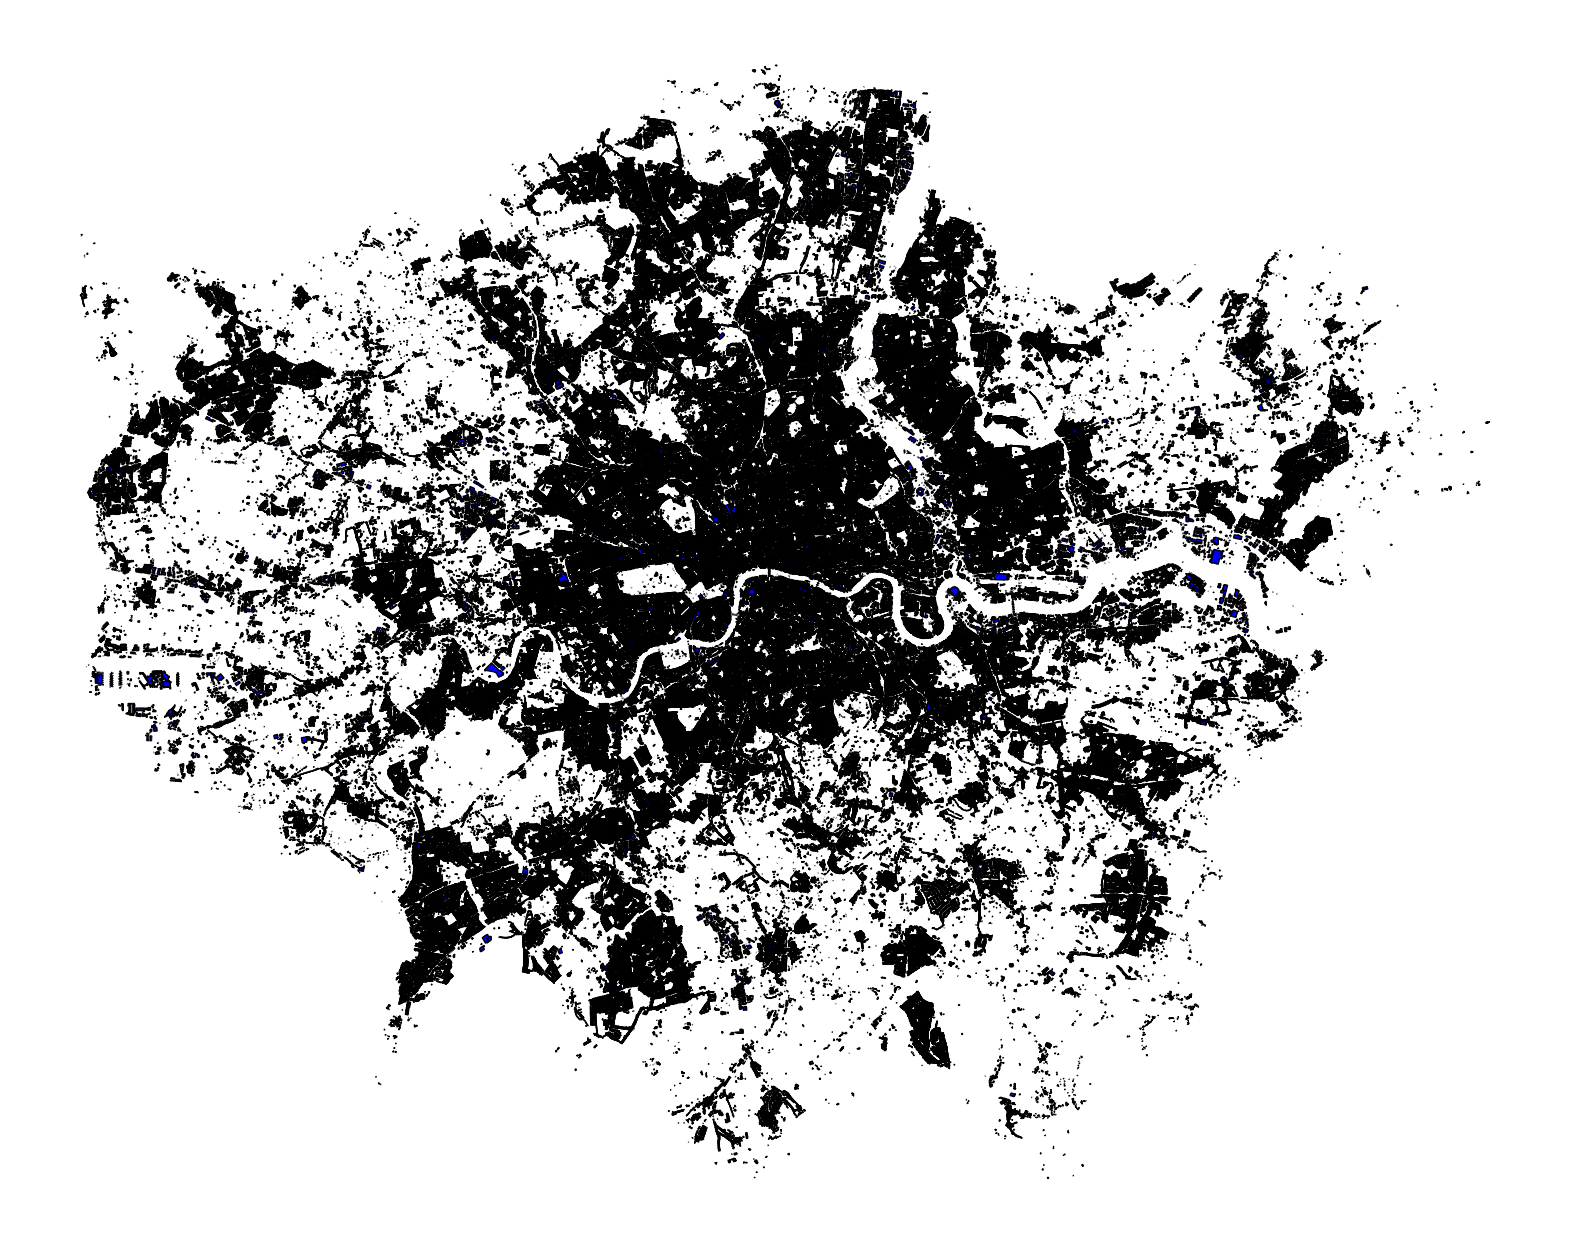

In [185]:
#Get all London

# Plot OSM buildings
fig, ax = plt.subplots(figsize=(20, 20))
building_footprints_combined.plot(ax=ax, legend=True, color='blue', edgecolor='black')
ax.set_axis_off()
plt.show()

A problem arises in that a lot of LSOAs are quite large. This is specifically true in the City of London (See City of London 001F)

### Dummy Model - Feature Counts + Population ONLY

In [222]:
#Before incorporating any more data into my model, I want to see how well COUNTS alone can predict employment at LSOA level

#Identifying variables (feature variables vs target to predict)
features = ['num_buildings', 'num_places', 'population']
target = 'total'

X = empl_geog[features]
y = empl_geog[target]

#Split into train/test - I know I need to make this spatially sensitive but we're just going with this for now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Init/train model
model = LinearRegression()
model.fit(X_train, y_train)

#Predictions
y_pred = model.predict(X_test)

#Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 4460587.330033497
R^2 Score: 0.31047839937648836


### Model incorporating POI categories + Building Geometry

In [215]:
# Function to extract slightly more information about the building footprints contained in each LSOA
def extract_multipolygon_features(multipolygon):
    if isinstance(multipolygon, MultiPolygon):
        polygons = list(multipolygon.geoms)
    elif isinstance(multipolygon, Polygon):
        polygons = [multipolygon]
    else:
        return pd.Series({
            'num_polygons': 0,
            'total_area': 0,
            'total_perimeter': 0,
            'avg_area': 0,
            'avg_perimeter': 0
        })

    num_polygons = len(polygons)
    areas = [polygon.area for polygon in polygons]
    perimeters = [polygon.length for polygon in polygons]
    total_area = sum(areas)
    total_perimeter = sum(perimeters)
    avg_area = total_area / num_polygons if num_polygons > 0 else 0
    avg_perimeter = total_perimeter / num_polygons if num_polygons > 0 else 0

    return pd.Series({
        'num_polygons': num_polygons,
        'total_area': total_area,
        'total_perimeter': total_perimeter,
        'avg_area': avg_area,
        'avg_perimeter': avg_perimeter
    })


geometry_features = empl_geog['building_poly'].apply(extract_multipolygon_features)
empl_geog = pd.concat([empl_geog, geometry_features], axis=1)


In [31]:
# Try again with extra polygon information

#Identifying variables (feature variables vs target to predict)
features = ['num_buildings', 'num_places', 'population', 'num_polygons', 'total_area', 'total_perimeter', 'avg_area', 'avg_perimeter']
target = 'total'

X = empl_geog[features]
y = empl_geog[target]

#Split into train/test - I know I need to make this spatially sensitive but we're just going with this for now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Init/train model
model = LinearRegression()
model.fit(X_train, y_train)

#Predictions
y_pred = model.predict(X_test)

#Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 4310381.751663163
R^2 Score: 0.333697312752121


In [265]:
# Encode POI categories in data - using One-Hot encoding

#Explode category lists
empl_geog_exploded = empl_geog.explode('category_list')

#Set up encoder
encoder = OneHotEncoder(sparse=False)

#Encode
encoded_categories = encoder.fit_transform(empl_geog_exploded[['category_list']])
encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['category_list']))

empl_geog_exploded = pd.concat([empl_geog_exploded.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Reaggregate
empl_geog_exploded.drop(columns=['category_list'], inplace=True)

# Group by LSOA11CD - sum numeric only
numeric_columns = encoded_df.columns.tolist() + ['num_buildings', 'num_places', 'population', 'total']
empl_geog_encoded = empl_geog_exploded.groupby('LSOA11CD')[numeric_columns].sum().reset_index()

empl_geog_encoded.head()

,LSOA11CD,category_list_3d_printing_service,category_list_abortion_clinic,category_list_abuse_and_addiction_treatment,category_list_accommodation,category_list_accountant,category_list_acoustical_consultant,category_list_active_life,category_list_acupuncture,category_list_addiction_rehabilitation_center,...,category_list_writing_service,category_list_yoga_instructor,category_list_yoga_studio,category_list_youth_organizations,category_list_zoo,category_list_nan,num_buildings,num_places,population,total
0,E01000001,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,5829,48843,294465,2886360
1,E01000002,0.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,14320,150002,514088,16326590
2,E01000003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,480,2640,64608,36480
3,E01000005,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,18681,255786,471815,10890065
4,E01000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,88,13624,840


In [34]:
# Create a model based on Geometry features and POI category information
features = ['num_buildings', 'num_places', 'population'] + list(encoded_df.columns)
target = 'total'

# Split the dataset - 80/20 train test
X_train, X_test, y_train, y_test = train_test_split(empl_geog_encoded[features], empl_geog_encoded[target], test_size=0.2, random_state=42)

# Initialize the model - Random Forest
model = RandomForestRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"\nMean Squared Error: {mse}")

r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")


Mean Squared Error: 1112066819209.984
R-squared: 0.4833689259209776


### With OSM vs Overture Buildings

In [232]:
#Create new version of empl_geog

empl_geog_osm = empl_geog.copy()

#Copied code from above
#Dealing with filter warnings for empty geometries in particular LSOAs
warnings.filterwarnings("ignore", category=FutureWarning)

#Iterate through all LSOAs and grab building and POI count - add to empl_geog dataframe

#New rows to store this data
empl_geog_osm['num_buildings'] = 0
empl_geog_osm['num_places'] = 0

for index, row in empl_geog_osm.iterrows():
    geom = row['geometry']
    filter_geom = gpd.GeoSeries([geom], crs=buildings.crs)
    
    #All Buildings
    filtered_buildings = building_footprints_combined[building_footprints_combined.geometry.intersects(filter_geom.unary_union)]

    #Multipolygon of each LSOA's buildings
    combined_multipolygon = filtered_buildings.geometry.unary_union
    
    #All Places
    filtered_places = places[places.geometry.intersects(filter_geom.unary_union)]

    #Multipoint of each LSOA's places
    combined_multipoint = filtered_places.geometry.unary_union

    #Add category information
    category_list = filtered_places['category'].dropna().tolist()

    #Add back to Dataframe
    empl_geog_osm.at[index, 'num_buildings'] = len(filtered_buildings)
    empl_geog_osm.at[index, 'num_places'] = len(filtered_places)
    empl_geog_osm.at[index, 'building_poly'] = combined_multipolygon
    empl_geog_osm.at[index, 'place_points'] = combined_multipoint
    empl_geog_osm.at[index, 'category_list'] = category_list
    
#Check
empl_geog_osm.head()


,LSOA11CD,LSOA11NM_x,population,geometry,Area,"01 : Crop and animal production, hunting and related service activities",02 : Forestry and logging,03 : Fishing and aquaculture,05 : Mining of coal and lignite,06 : Extraction of crude petroleum and natural gas,...,num_buildings,num_places,building_poly,place_points,category_list,num_polygons,total_area,total_perimeter,avg_area,avg_perimeter
0,E01000001,City of London 001A,1465,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",lsoa2011:E01000001 : City of London 001A,0,0,0,0,10,...,86,243,"MULTIPOLYGON (((-0.0983297 51.5158158, -0.0983...","MULTIPOINT ((-0.0987982 51.5176724), (-0.09860...","[pub, coffee_shop, immigration_law, shared_off...",23.0,0.000004,0.047174,1.769159e-07,0.002051
1,E01000002,City of London 001B,1436,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",lsoa2011:E01000002 : City of London 001B,0,0,0,0,0,...,96,419,"MULTIPOLYGON (((-0.0945314 51.5147658, -0.0944...","MULTIPOINT ((-0.0958288 51.5168656), (-0.09565...","[business_manufacturing_and_supply, education,...",31.0,0.000009,0.094122,2.967700e-07,0.003036
2,E01000003,City of London 001C,1346,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",lsoa2011:E01000003 : City of London 001C,0,0,0,0,0,...,29,55,"MULTIPOLYGON (((-0.0959637 51.5209148, -0.0959...","MULTIPOINT ((-0.0976057 51.5226912), (-0.09757...","[health_and_medical, hospital, parking, indust...",9.0,0.000002,0.023994,1.958632e-07,0.002666
3,E01000005,City of London 001E,985,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",lsoa2011:E01000005 : City of London 001E,0,10,0,0,0,...,133,534,"MULTIPOLYGON (((-0.0757822 51.511071, -0.07577...","MULTIPOINT ((-0.0799241 51.5156172), (-0.07992...","[professional_services, dance_club, insurance_...",32.0,0.000005,0.052988,1.549158e-07,0.001656
4,E01000006,Barking and Dagenham 016A,1703,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",lsoa2011:E01000006 : Barking and Dagenham 016A,0,0,0,0,0,...,280,11,"MULTIPOLYGON (((0.085895 51.5386732, 0.0859413...","MULTIPOINT ((0.0856198 51.538706), (0.0858424 ...","[landmark_and_historical_building, constructio...",0.0,0.000000,0.000000,0.000000e+00,0.000000


In [304]:
# Encode POI categories in data - using One-Hot encoding

#Explode category lists
empl_geog_osm_exploded = empl_geog_osm.explode('category_list')

#Set up encoder
encoder = OneHotEncoder(sparse=False)

#Encode
encoded_categories = encoder.fit_transform(empl_geog_osm_exploded[['category_list']])
encoded_df_osm = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(['category_list']))

empl_geog_osm_exploded = pd.concat([empl_geog_osm_exploded.reset_index(drop=True), encoded_df_osm.reset_index(drop=True)], axis=1)

# Reaggregate
empl_geog_osm_exploded.drop(columns=['category_list'], inplace=True)

# Group by LSOA11CD - sum numeric only
numeric_columns = encoded_df_osm.columns.tolist() + ['num_polygons', 'total_area', 'total_perimeter', 'avg_area', 'avg_perimeter', 'num_buildings', 'num_buildings', 'num_places', 'population', 'total']
empl_geog_osm_encoded = empl_geog_osm_exploded.groupby('LSOA11CD')[numeric_columns].sum().reset_index()

empl_geog_osm_encoded.head()

,LSOA11CD,category_list_3d_printing_service,category_list_abortion_clinic,category_list_abuse_and_addiction_treatment,category_list_accommodation,category_list_accountant,category_list_acoustical_consultant,category_list_active_life,category_list_acupuncture,category_list_addiction_rehabilitation_center,...,num_polygons,total_area,total_perimeter,avg_area,avg_perimeter,num_buildings,num_buildings,num_places,population,total
0,E01000001,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,4623.0,0.000818,9.481912,0.000036,0.412257,5829,5829,48843,294465,2886360
1,E01000002,0.0,0.0,0.0,1.0,5.0,0.0,0.0,1.0,0.0,...,11098.0,0.003294,33.695567,0.000106,1.086954,14320,14320,150002,514088,16326590
2,E01000003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,432.0,0.000085,1.151718,0.000009,0.127969,480,480,2640,64608,36480
3,E01000005,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,15328.0,0.002375,25.381055,0.000074,0.793158,18681,18681,255786,471815,10890065
4,E01000006,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0,88,13624,840


In [306]:
#Execute the model

features = ['num_polygons', 'total_area', 'total_perimeter', 'avg_area', 'avg_perimeter', 'num_buildings', 'num_places', 'population'] + list(encoded_df_osm.columns)
target = 'total'

# Split the dataset - 80/20 train test
X_train, X_test, y_train, y_test = train_test_split(empl_geog_osm_encoded[features], empl_geog_osm_encoded[target], test_size=0.2, random_state=42)

# Initialize the model - Random Forest
model = RandomForestRegressor(random_state=42)

# Train the model

model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"\nMean Squared Error: {mse}")

r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared}")


Mean Squared Error: 1951593948979.6047
R-squared: 0.09335117224006273


### Spatial Indexing - H3

In [108]:
# I want to convert all my statistics to an H3 grid but I don't know if this is a scientifically rigorous method just yet?

#Polyfill
#Resolution 8 for H3 corresponds to hexagons with sides of length ~170m
resolution = 9

# Generate grid cells for London
london_h3 = set()
for feature in lsoa_geo.geometry.unary_union.geoms:
    london_h3.update(h3.polyfill(mapping(feature), resolution))


In [116]:
print(len(london_h3))

# I want to get buildings and POIs for each hex which will be easy using Overture. I will also want to get an
# estimated employment count which will be much more difficult

27195
